## Importing necessary libraries

In [1]:
import warnings
import numpy as np
import pandas as pd
import yfinance as yf
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

## Companies dictionary for stock tickers
This section defines a dictionary where each company name is mapped to its respective stock ticker symbol. The ticker symbol is used to fetch stock data from financial APIs, such as Yahoo Finance.

In [2]:
companies = {'Reliance Industries Limited': 'RELIANCE.NS',
 'Tata Consultancy Services Limited': 'TCS.NS',
 'HDFC Bank Limited': 'HDFCBANK.NS',
 'Infosys Limited': 'INFY.NS',
 'ICICI Bank Limited': 'ICICIBANK.NS',
 'Kotak Mahindra Bank Limited': 'KOTAKBANK.NS',
 'Wipro Limited': 'WIPRO.NS',
 'Bharti Airtel Limited': 'BHARTIARTL.NS',
 'HCL Technologies Limited': 'HCLTECH.NS',
 'Axis Bank Limited': 'AXISBANK.NS',
 'Maruti Suzuki India Limited': 'MARUTI.NS',
 'NTPC Limited': 'NTPC.NS',
 'Adani Enterprises Limited': 'ADANIENT.NS',
 'Hero MotoCorp Limited': 'HEROMOTOCO.NS',
 'Tata Motors Limited': 'TATAMOTORS.NS',
 'Mahindra & Mahindra Limited': 'M&M.NS',
 'Bharat Petroleum Corporation Limited': 'BPCL.NS',
 'Oil and Natural Gas Corporation Limited': 'ONGC.NS',
 'Coal India Limited': 'COALINDIA.NS',
 'Power Grid Corporation of India Limited': 'POWERGRID.NS'}

## Function to load stock data for a selected company
This function allows the user to select a company from a list. Based on the selection, it fetches historical stock data from Yahoo Finance. The data is retrieved for the selected company starting from January 1, 2001, to the current date. The stock data includes columns like Date, Open, High, Low, Close, and Volume, which are essential for technical analysis.

In [3]:
def load_data():
    print("Select a company to fetch data:")
    for i, company in enumerate(companies.keys(), 1):
        print(f"{i}. {company}")

    choice = int(input("Enter the number of your choice: "))
    company_name = list(companies.keys())[choice - 1]
    ticker = companies[company_name]

    print(f"You selected: {company_name}")

    from_date_str = '2001-01-01'
    to_date_str = datetime.now().strftime('%Y-%m-%d')

    stock = yf.Ticker(ticker)
    index_data = stock.history(start=from_date_str, end=to_date_str)

    index_data.reset_index(inplace=True)

    index_data['Date'] = index_data['Date'].apply(lambda x : str(x)[:10])
    index_data = index_data[['Date', 'Open','High', 'Low', 'Close', 'Volume']]
    
    return index_data

## Function to calculate technical indicators
In this section, common technical indicators are calculated:
- Simple Moving Averages (SMA): 50-day and 200-day SMAs are calculated to identify trends.
- Exponential Moving Averages (EMA): Short (12-day) and long (26-day) EMAs are computed to capture more recent price movements.
- MACD (Moving Average Convergence Divergence): This is derived from the difference between the 12-day and 26-day EMAs, which helps identify momentum changes.
- RSI (Relative Strength Index): The RSI measures the speed and change of price movements and helps to determine whether a stock is overbought or oversold.

In [4]:
def calculate_indicators(data):
    data['SMA_50'] = data['Close'].rolling(window=50).mean()
    data['SMA_200'] = data['Close'].rolling(window=200).mean()

    short_window = 12
    long_window = 26
    signal_window = 9

    data['EMA_12'] = data['Close'].ewm(span=short_window, adjust=False).mean()
    data['EMA_26'] = data['Close'].ewm(span=long_window, adjust=False).mean()
    data['MACD'] = data['EMA_12'] - data['EMA_26']
    data['MACD_Signal'] = data['MACD'].ewm(span=signal_window, adjust=False).mean()

    rsi_period = 14
    delta = data['Close'].diff(1)
    gain = delta.where(delta > 0, 0).rolling(window=rsi_period).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=rsi_period).mean()
    
    rs = gain / loss.replace(0, np.nan)
    data['RSI'] = 100 - (100 / (1 + rs))

    return data

## Function to generate buy and sell signals
This function uses the previously calculated indicators to generate buy and sell signals:
- Buy Signal: The stock is a potential buy when the price is above the 50-day SMA, the MACD is above its signal line, and the RSI is between 30 and 70 (neutral zone).
- Sell Signal: The stock is a potential sell when the price is below the 50-day SMA, the MACD is below its signal line, or the RSI is above 70 (indicating overbought conditions).

In [5]:
def generate_signals(data):
    data['Buy_Signal'] = ((data['Close'] > data['SMA_50']) & 
                          (data['MACD'] > data['MACD_Signal']) & 
                          (data['RSI'] > 30) & (data['RSI'] < 70))

    data['Sell_Signal'] = ((data['Close'] < data['SMA_50']) |
                           (data['MACD'] < data['MACD_Signal']) |
                           (data['RSI'] > 70))
    return data

## Function to get the latest trading signal
This function checks the most recent data point (latest row) and determines the trading action to take:
- Buy: If the latest data meets the conditions for a buy signal.
- Sell: If the latest data meets the conditions for a sell signal.
- Hold: If neither buy nor sell conditions are met.

In [6]:
def get_latest_signal(data):
    latest_data = data.iloc[-1]
    signal = "Hold"
    if latest_data['Buy_Signal']:
        signal = "Buy"
    elif latest_data['Sell_Signal']:
        signal = "Sell"
    return signal

## Main function to run the program
This is the main function that integrates everything:
- It prompts the user to select a company and fetches its stock data.
- It calculates the necessary technical indicators.
- It generates buy or sell signals based on the data.
- It visualizes the stock price, moving averages, and RSI using Plotly.
- It provides the latest trading signal (buy, sell, or hold).
- It displays the plot for the stock's price and indicators as well as a separate plot for the RSI, with thresholds indicating overbought and oversold levels.

In [7]:
def main():
    warnings.simplefilter(action='ignore', category=FutureWarning)

    data = load_data() 
    data = calculate_indicators(data)
    data = generate_signals(data)

    latest_signal = get_latest_signal(data)
    print(f"Based on the latest available data, the recommended action for tomorrow is: {latest_signal}")

    data['Date'] = pd.to_datetime(data['Date'])

    dates = data['Date'].dt.to_pydatetime()

    trace_close = go.Scatter(x=dates, y=data['Close'], mode='lines', name='Close Price', line=dict(color='blue'))
    trace_sma50 = go.Scatter(x=dates, y=data['EMA_12'], mode='lines', name='12-day EMA', line=dict(color='red'))
    trace_sma200 = go.Scatter(x=dates, y=data['EMA_26'], mode='lines', name='26-day EMA', line=dict(color='green'))
    trace_rsi = go.Scatter(x=dates, y=data['RSI'], mode='lines', name='26-day EMA', line=dict(color='green'))


    fig = go.Figure(data=[trace_close, trace_sma50, trace_sma200])
    fig.update_layout(
        title='Stock Data with Indicators and Signals',
        xaxis_title='Date',
        yaxis_title='Value',
        hovermode='x',
        xaxis_rangeslider_visible=True,
        width=1200,
        height=800
    )
    fig.show()

    fig_1 = go.Figure(data=[trace_rsi])
    fig_1.update_layout(
        title='RSI',
        xaxis_title='Date',
        yaxis_title='Value',
        hovermode='x',
        xaxis_rangeslider_visible=True,
        width=1200,
        height=800
    )

    fig_1.add_shape(type="line",
                    x0=dates[0], x1=dates[-1], y0=70, y1=70,
                    line=dict(color="red", width=2, dash="dash"))

    fig_1.add_shape(type="line",
                    x0=dates[0], x1=dates[-1], y0=30, y1=30,
                    line=dict(color="red", width=2, dash="dash"))

    fig_1.show()

Select a company to fetch data:
1. Reliance Industries Limited
2. Tata Consultancy Services Limited
3. HDFC Bank Limited
4. Infosys Limited
5. ICICI Bank Limited
6. Kotak Mahindra Bank Limited
7. Wipro Limited
8. Bharti Airtel Limited
9. HCL Technologies Limited
10. Axis Bank Limited
11. Maruti Suzuki India Limited
12. NTPC Limited
13. Adani Enterprises Limited
14. Hero MotoCorp Limited
15. Tata Motors Limited
16. Mahindra & Mahindra Limited
17. Bharat Petroleum Corporation Limited
18. Oil and Natural Gas Corporation Limited
19. Coal India Limited
20. Power Grid Corporation of India Limited


Enter the number of your choice:  1


You selected: Reliance Industries Limited
Based on the latest available data, the recommended action for tomorrow is: Sell


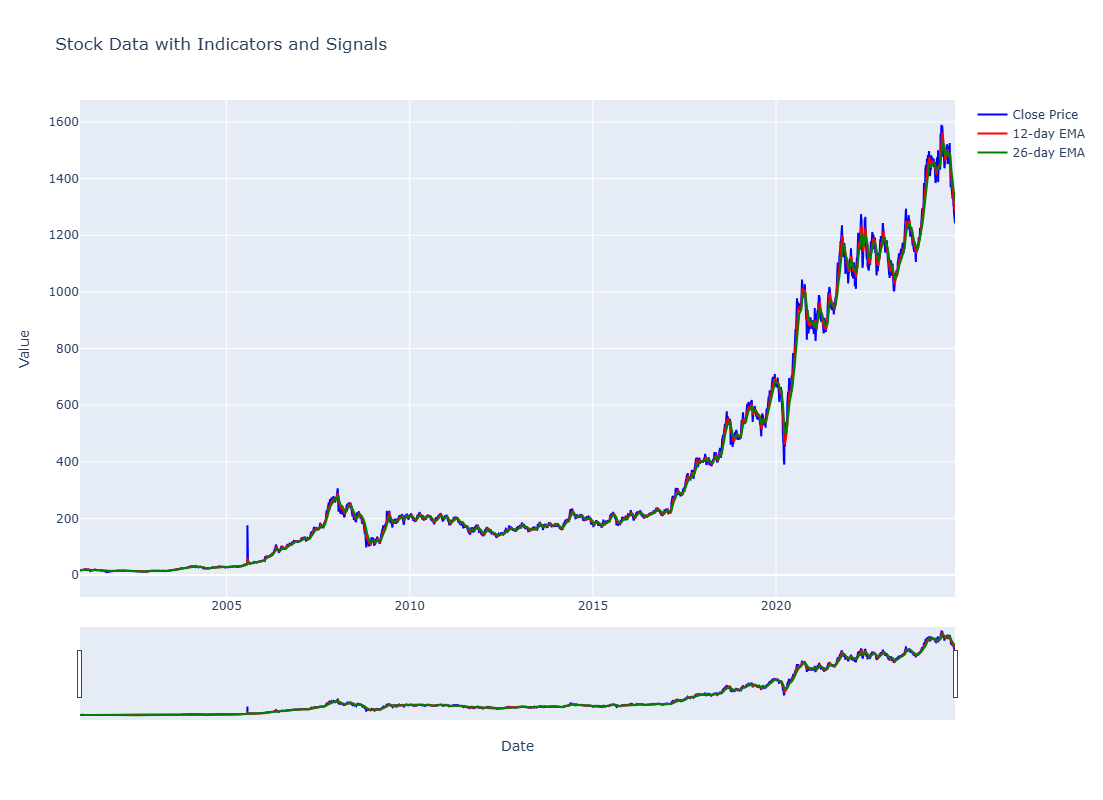

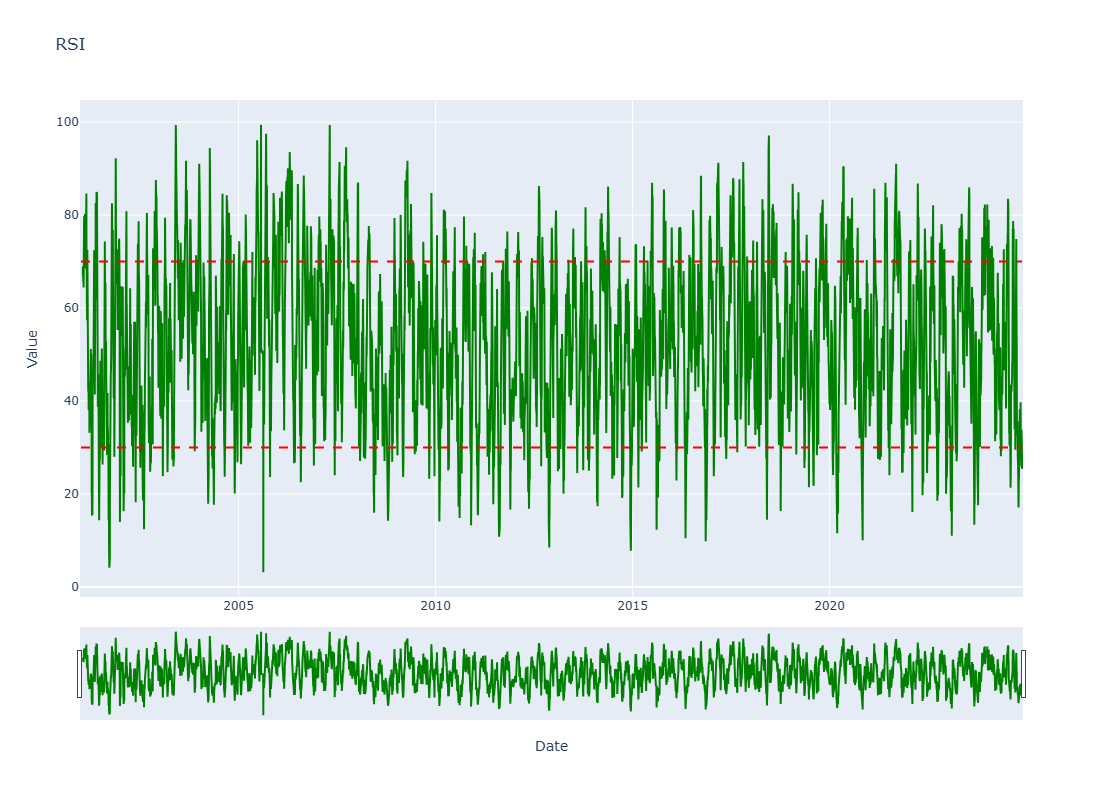

In [8]:
main()

In [9]:
load_data().tail()

Select a company to fetch data:
1. Reliance Industries Limited
2. Tata Consultancy Services Limited
3. HDFC Bank Limited
4. Infosys Limited
5. ICICI Bank Limited
6. Kotak Mahindra Bank Limited
7. Wipro Limited
8. Bharti Airtel Limited
9. HCL Technologies Limited
10. Axis Bank Limited
11. Maruti Suzuki India Limited
12. NTPC Limited
13. Adani Enterprises Limited
14. Hero MotoCorp Limited
15. Tata Motors Limited
16. Mahindra & Mahindra Limited
17. Bharat Petroleum Corporation Limited
18. Oil and Natural Gas Corporation Limited
19. Coal India Limited
20. Power Grid Corporation of India Limited


Enter the number of your choice:  1


You selected: Reliance Industries Limited


Date         Open         High          Low        Close    Volume
5943  2024-11-12  1275.550049  1289.300049  1267.500000  1274.250000  10671091
5944  2024-11-13  1270.250000  1275.449951  1249.500000  1252.050049  14633633
5945  2024-11-14  1253.599976  1272.599976  1251.099976  1267.599976  12612633
5946  2024-11-18  1267.599976  1272.900024  1243.900024  1260.750000  13620611
5947  2024-11-19  1260.750000  1281.500000  1235.150024  1241.650024  14183746